## I. Introduction

Ce notebook a pour vocation de vérifier une nouvelle fois les résultats des prédictions faites à l'aide des modèles EfficientNetV2B3 & EfficientNetV2S mais cette fois à l'aide de matrices de confusion et de rapports de classification.  
<br>

Ces 2 modèles ont été utilisés pour les dernières comparaisons de modèle pour la classification 14 classes (type de plantes).  
<br>



## II. Chargement des données et preprocessing

### a. Importation des librairies nécessaires

In [1]:
#Importation des librairies de base nécessaires
import os
import io
import gzip
import random
import argparse
from time import time
from datetime import date
from timeit import default_timer as timer

#Importation des librairies de nécessaire à la gestion des données
import numpy as np
import pandas as pd

#Importation des librairies d'affichage de graphiques
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#Importation des librairies tensorflow keras nécessaires
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Sequential, datasets, layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2, MobileNetV2, EfficientNetB0
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetB4, EfficientNetV2B3, Xception, InceptionV3
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#Librairies de pre-processing input si existante (enlever le commentaire quand nécessaire)
#from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
#from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
#from tensorflow.keras.applications.inception_v3 import preprocess_input
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#from tensorflow.keras.applications.xception import preprocess_input

#Librairies additionelles pour la modélisation
from vit_keras import vit
from tensorflow.python.client import device_lib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

D:\Programs\Anaconda3\envs\My_GPU_TensorFL0W\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### b. Vérification de la configuration tensorflow avec GPU

In [2]:
#Check que la version GPU de TensorFlow est bien activée et que le GPU est trouvé
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Récupération du nom du périphérique GPU
devices = device_lib.list_local_devices()
descriptions = [device.physical_device_desc for device in devices]
for desc in descriptions:
    print(desc)

Num GPUs Available:  1

device: 0, name: NVIDIA GeForce RTX 4090 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### c. Chargement des données

In [3]:
%store -r df_NPD

In [4]:
df_NPD.head()

,Categorie,Plante,Maladie,Saine,Suffixe,Abrev,AbrevMaladie,Rotation,Luminosite,Symetrie,...,Mode,Profondeur de couleur,Moyenne R,Moyenne G,Moyenne B,Taille du fichier,Set,DirPath,FileName,FilePath
0,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,109.957947,129.504242,119.117355,9606,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
1,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,110.123795,129.669220,119.235626,9960,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
2,Apple__Apple_scab,Apple,Apple_scab,0,new30degfliplr.jpg,FREC,Scab,30,0,LR,...,RGB,8,89.325546,109.759598,95.272110,10299,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
3,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,92.044342,125.152634,115.290207,11986,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
4,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,129.272934,125.058243,113.740295,20194,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...


In [5]:
#Récupération des données des set train et valid dans 2 nouveaux dataframes
train_data = df_NPD[df_NPD["Set"] == "train"]
valid_data = df_NPD[df_NPD["Set"] == "valid"]

### d. Vérification et équilibrage des données

#### 1-A. Vérification des données pour l'analyse "Type de Plante"

In [13]:
#Décompte des valeurs de la classe "Plante" pour les histogrammes
train_plant_counts = train_data["Plante"].value_counts()
valid_plant_counts = valid_data["Plante"].value_counts()

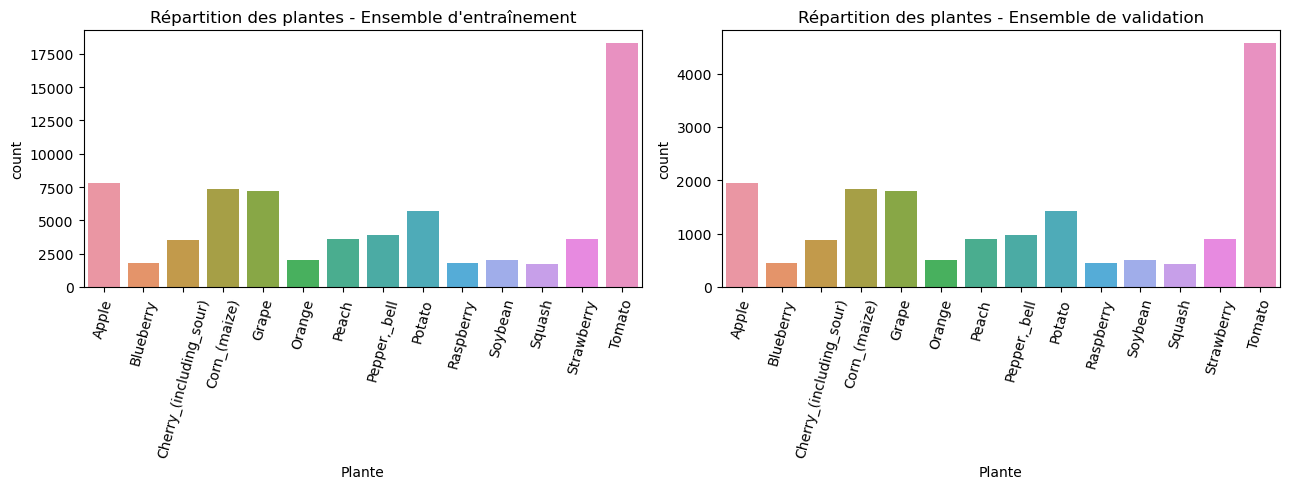

In [14]:
#Création d'une figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

#Premier graphique pour train_data
sns.countplot(data=train_data, x='Plante', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=75)
axes[0].set_title('Répartition des plantes - Ensemble d\'entraînement')

#Deuxième graphique pour valid_data
sns.countplot(data=valid_data, x='Plante', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=75)
axes[1].set_title('Répartition des plantes - Ensemble de validation')

#Affichage
plt.tight_layout()
plt.show()

#### 1-B. Equilibrage des données pour l'analyse "Type de Plante"

In [15]:
#Copie des données d'origine
train_data_plant = train_data.copy()

#Décompte du nombre d'échantillons souhaité basé sur le type "Potato"
potato_count = train_data_plant[train_data_plant['Plante'] == 'Potato'].shape[0]

#Création d'un DataFrame pour stocker les échantillons équilibrés
balanced_samples = pd.DataFrame(columns=train_data.columns)

#On parcoure chaque type de plante
for plant_type, group in train_data_plant.groupby('Plante'):
    #Puis on vérifie si le type de plante est différent de "Potato"
    if plant_type != 'Potato':
        #On échantillonne jusqu'à atteindre le nombre désiré de plante par type
        group_samples = group.sample(n=potato_count, replace=True, random_state=111)
        #On ajoute les échantillons équilibrés au DataFrame
        balanced_samples = pd.concat([balanced_samples, group_samples])

#Ajout des échantillons du type "Potato" au DataFrame équilibré
train_data_plant_balanced = pd.concat([balanced_samples, train_data_plant[train_data_plant['Plante'] == 'Potato']])

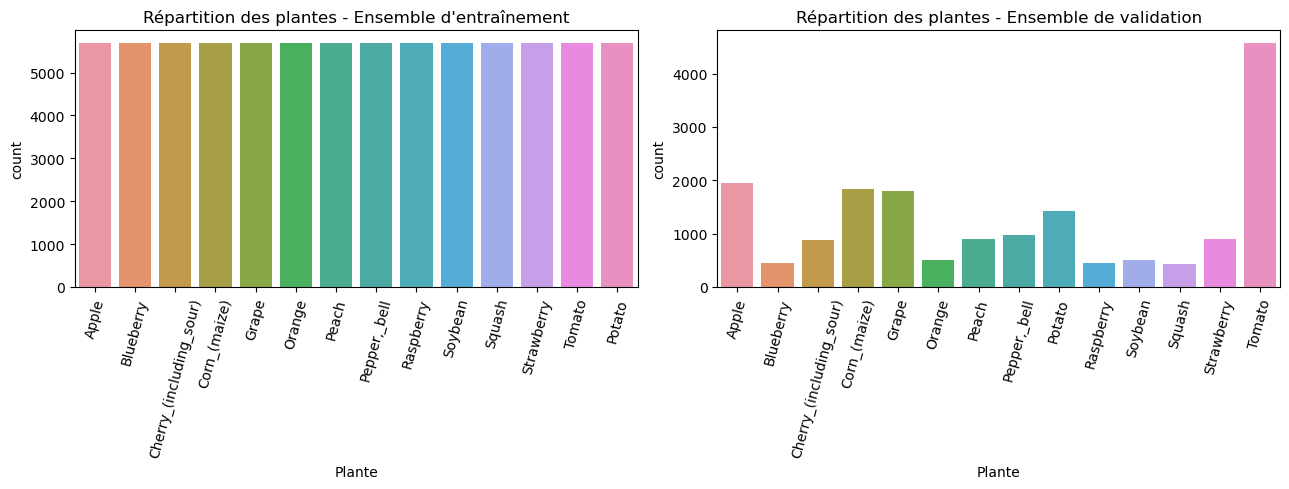

In [16]:
#Création d'une figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

#Premier graphique pour train_data
sns.countplot(data=train_data_plant_balanced, x='Plante', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=75)
axes[0].set_title('Répartition des plantes - Ensemble d\'entraînement')

#Deuxième graphique pour valid_data
sns.countplot(data=valid_data, x='Plante', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=75)
axes[1].set_title('Répartition des plantes - Ensemble de validation')

#Affichage
plt.tight_layout()
plt.show()

In [17]:
#l'équilibrage semble avoir été bien fait sur le set Train.
#   On met le set équilibré dans un nouveau dataframe dans un but d'homogéïnisation des noms.
train_data_plant = train_data_plant_balanced

In [18]:
#Copie également du set valid dans un nouveau dataframe toujours pour une raison de convention de nommage.
#   Et également pour garder les set initiaux intactes.
valid_data_plant = valid_data

### e. Pré-processing additionnel sur les données

#### 1. Création d'un ImageDataGenerator pour chacun des 2 sets

In [24]:
#Création du générateur d'image pour Train avec beaucoup de nouvelles modifications bien que les images aient été
#   déjà augmentées. Cela afin d'éviter un sur-apprentissage sur des images trop similaires.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255,
                                   shear_range=0.2, brightness_range=(0.4,1.7),
                                   zoom_range=0.5, rotation_range=40,
                                   width_shift_range=0.3, height_shift_range=0.3,
                                   horizontal_flip=True, vertical_flip=True,
                                   fill_mode='nearest')

#Création du générateur d'image pour Valid avec seulement des modifications cohérentes avec ce qu'on pourrait
#   trouver dans la nature.
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255, 
                                   brightness_range=(0.6,1.2),
                                   zoom_range=0.5, rotation_range=40,
                                   horizontal_flip=True, vertical_flip=True)

#Création d'un set sans modification pour afficher les modifications apportées
norm_datagen = ImageDataGenerator(rescale=1./255)

#### 2. Vérification des modifications appliquées sur les images

__Set Train__

Found 96000 validated image filenames belonging to 2 classes.
Found 96000 validated image filenames belonging to 2 classes.


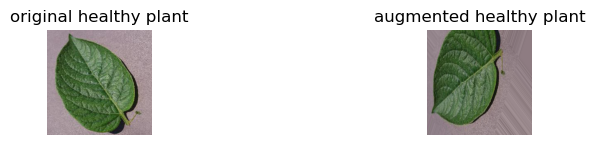

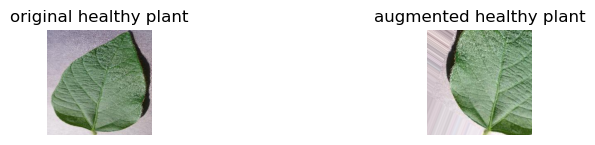

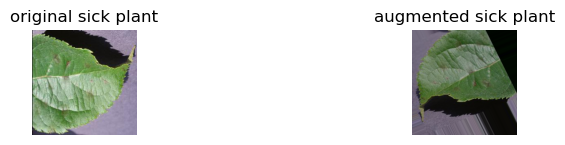

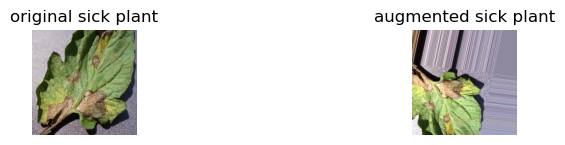

In [25]:
#Affichage de 2x4 images aléatoires
batches_real = norm_datagen.flow_from_dataframe(dataframe=train_data_health, directory=None, x_col='FilePath', y_col='Saine', 
                                                 target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                 seed=111)

batches_augmented = train_datagen.flow_from_dataframe(dataframe=train_data_health, directory=None, x_col='FilePath', y_col='Saine', 
                                                      target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                      seed=111)

x_batch_augmented, y_batch_augmented = next(batches_augmented)
x_batch_real, y_batch_real = next(batches_real)

for i in range(4):
    plt.figure(figsize=(9, 3))
    
    image_augmented = x_batch_augmented[i]
    image_real = x_batch_real[i]
    
    title_add_on = "sick plant"
    if y_batch_augmented[i][1]: title_add_on =  "healthy plant"

    plt.subplot(221)
    plt.imshow(image_real)
    plt.title("original " + title_add_on)
    plt.axis('off')
        
    plt.subplot(222)
    plt.imshow(image_augmented)
    plt.title("augmented " + title_add_on)
    plt.axis('off')

    plt.show()

__Set Valid__

Found 17571 validated image filenames belonging to 2 classes.
Found 17571 validated image filenames belonging to 2 classes.


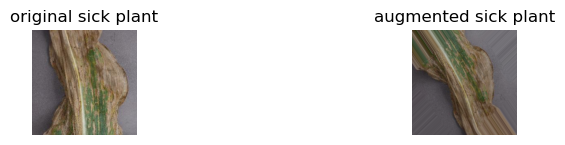

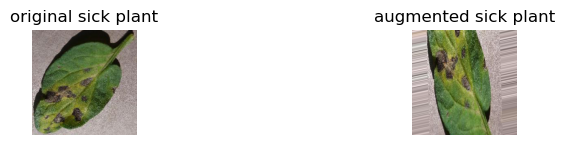

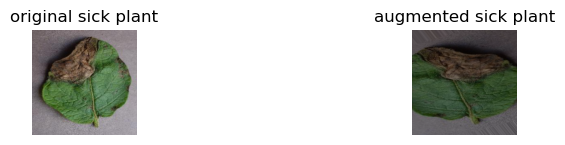

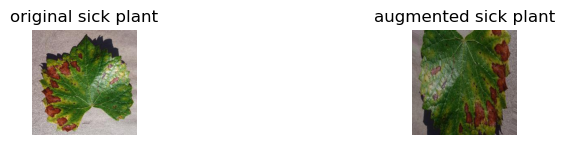

In [26]:
#Affichage de 2x8 images aléatoires
batches_real = norm_datagen.flow_from_dataframe(dataframe=valid_data_health, directory=None, x_col='FilePath', y_col='Saine', 
                                                 target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                 seed=111)

batches_augmented = valid_datagen.flow_from_dataframe(dataframe=valid_data_health, directory=None, x_col='FilePath', y_col='Saine', 
                                                      target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                      seed=111)

x_batch_augmented, y_batch_augmented = next(batches_augmented)
x_batch_real, y_batch_real = next(batches_real)

for i in range(4):
    plt.figure(figsize=(9, 3))
    
    image_augmented = x_batch_augmented[i]
    image_real = x_batch_real[i]
    
    title_add_on = "sick plant"
    if y_batch_augmented[i][1]: title_add_on =  "healthy plant"

    plt.subplot(221)
    plt.imshow(image_real)
    plt.title("original " + title_add_on)
    plt.axis('off')
        
    plt.subplot(222)
    plt.imshow(image_augmented)
    plt.title("augmented " + title_add_on)
    plt.axis('off')    
    
    plt.show()

### f. Création des datasets

#### 1. Création des Dataset pour l'analyse "Type de Plante"

In [28]:
print("Création du set d'entraînement avec le générateur d'image :")
training_set_plant = train_datagen.flow_from_dataframe(
    dataframe=train_data_plant,
    directory=None,   #None car nous utilisons "FilePath" du dataframe pour charger les images
    x_col='FilePath',   #Colonne contenant les chemins des fichiers
    y_col='Plante',   #Colonne contenant les étiquettes
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=111
)

print("\nCréation du set de validation avec le générateur d'image :")
valid_set_plant = valid_datagen.flow_from_dataframe(
    dataframe=valid_data_plant,
    directory=None,   #None car nous utilisons "FilePath" du dataframe pour charger les images
    x_col='FilePath',   #Colonne contenant les chemins des fichiers
    y_col='Plante',   #Colonne contenant les étiquettes
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=False
)

Création du set d'entraînement avec le générateur d'image :
Found 79828 validated image filenames belonging to 14 classes.

Création du set de validation avec le générateur d'image :
Found 17571 validated image filenames belonging to 14 classes.


## III. Chargement de la sauvegarde des modèles entrainées

### a. Chargement du modèle EfficientNetV2B3

In [30]:
#Répertoire root
cwd = os.getcwd()

#### 1. Chargement du modèle EfficientNetV2B3 pour l'analyse "Type de Plante"

In [33]:
#Chargement du meilleur modèle sauvegardé lors d'un entraînement précédent
eNetV2B3_plant_model_path = cwd + "\\Saved Models\\Best Of\\eNetV2B3_Final-Plant_Recog-Full_Model-ENDSAVE.h5"
eNetV2B3_classifier_plant = models.load_model(eNetV2B3_plant_model_path)

In [34]:
eNetV2B3_classifier_plant.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 7, 7, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

### b. Chargement du modèle EfficientNetV2S

#### 1. Chargement du modèle EfficientNetV2S pour l'analyse "Type de Plante"

In [39]:
#Chargement du meilleur modèle sauvegardé lors d'un entraînement précédent
eNetV2S_plant_model_path = cwd + "\\Saved Models\\Best Of\\eNetV2S_Final-Plant_Recog-Full_Model-ENDSAVE.h5"
eNetV2S_classifier_plant = models.load_model(eNetV2S_plant_model_path)

In [40]:
eNetV2S_classifier_plant.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

## IV. Evaluation des prédictions avec des images tests

### a. Evaluation des prédictions sur le type de plante

#### 1. Evalutation du modèle EfficientNetV2B3

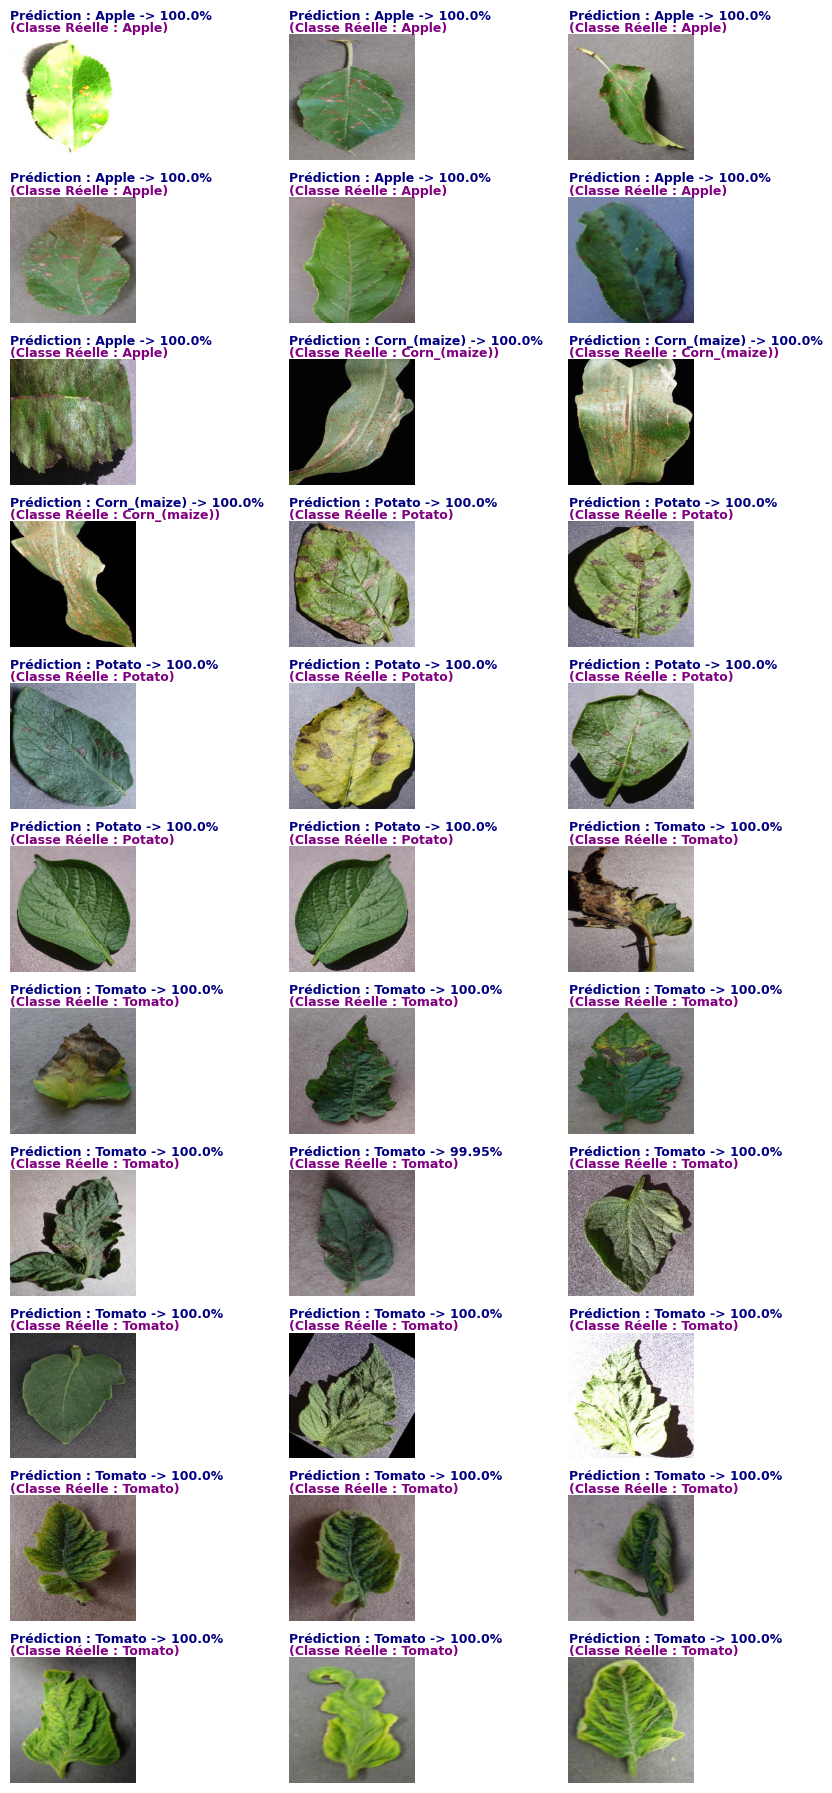

In [45]:
#Chemin du répertoire contenant les images
image_dir = r"C:\Users\flore\Jupyter\Recog_Plant_Disease\Datasets\NPD\test\Test___Pictures_Random"

#Obtention de la liste des fichiers images
file_list = os.listdir(image_dir)

#Sélection des 33 fichiers images
selected_files = file_list[:33]

#Configuration des sous-plots
num_rows = 11
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#Obtention de la correspondance entre les étiquettes numériques et les noms de classe
class_mapping = training_set_plant.class_indices

#Inversion de la correspondance pour obtenir les noms de classe
class_names = {v: k for k, v in class_mapping.items()}

#Boucle pour prédire et afficher les images
for i, file in enumerate(selected_files):
    file_path = os.path.join(image_dir, file)

    #Chargement et prétraitement de l'image
    img = image.load_img(file_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.
    img_tensor = np.expand_dims(img_array, axis=0)

    #Prédiction de la classe
    predictions = eNetV2B3_classifier_plant.predict(img_tensor, verbose=0)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    predicted_proba = round(100 * predictions[0][predicted_class_index], 2)
    
    #Classe réelle
    if "Apple" in file:
        real_class = "Apple"
    elif "Blueberry" in file:
        real_class = "Blueberry"
    elif "Cherry" in file:
        real_class = "Cherry_(including_sour)"
    elif "Corn" in file:
        real_class = "Corn_(maize)"
    elif "Grape" in file:
        real_class = "Grape"
    elif "Orange" in file:
        real_class = "Orange"
    elif "Peach" in file:
        real_class = "Peach"
    elif "Pepper" in file:
        real_class = "Pepper,_bell"
    elif "Raspberry" in file:
        real_class = "Raspberry"
    elif "Soybean" in file:
        real_class = "Soybean"
    elif "Squash" in file:
        real_class = "Squash"
    elif "Strawberry" in file:
        real_class = "Strawberry"
    elif "Tomato" in file:
        real_class = "Tomato"
    elif "Potato" in file:
        real_class = "Potato"
    else:
        real_class = "Unknown"

    #Chargement et affichage de l'image
    img = mpimg.imread(file_path)
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(img)
    ax.axis('off')    
    ax.text(0, -30, 'Prédiction : ' + predicted_class + ' -> ' + str(predicted_proba) + '%',
            color='navy', fontsize=9, fontweight='bold')
    ax.text(0, -5, '(Classe Réelle : ' + real_class + ')',
            color='purple', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

#### 2. Evalutation du modèle EfficientNetV2S

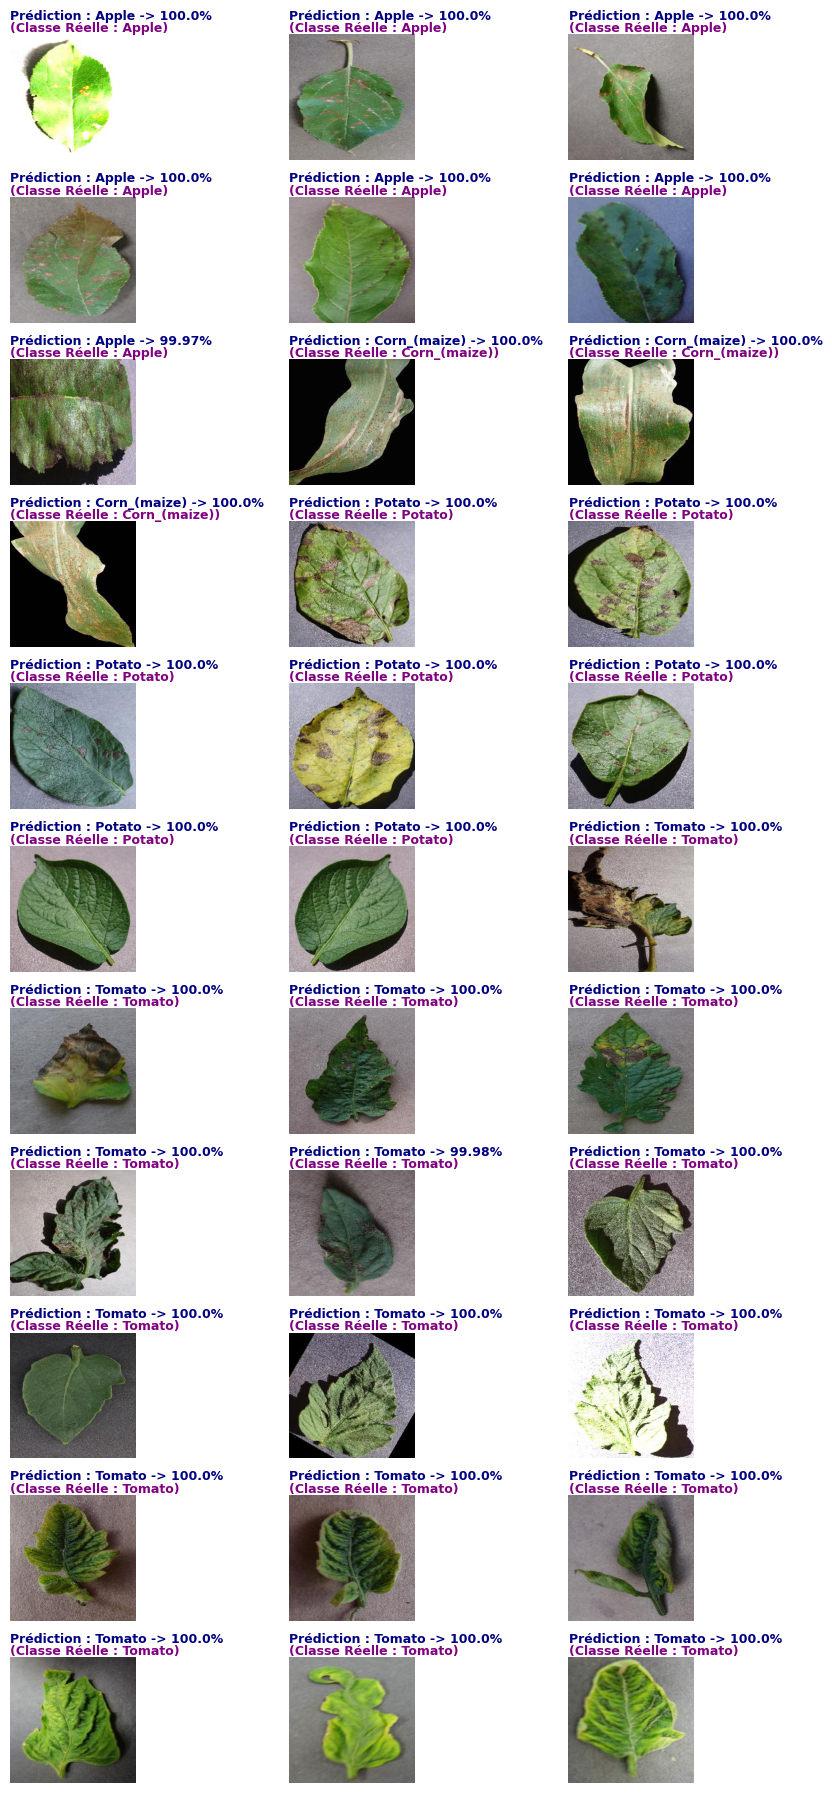

In [46]:
#Chemin du répertoire contenant les images
image_dir = r"C:\Users\flore\Jupyter\Recog_Plant_Disease\Datasets\NPD\test\Test___Pictures_Random"

#Obtention de la liste des fichiers images
file_list = os.listdir(image_dir)

#Sélection des 33 fichiers images
selected_files = file_list[:33]

#Configuration des sous-plots
num_rows = 11
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#Obtention de la correspondance entre les étiquettes numériques et les noms de classe
class_mapping = training_set_plant.class_indices

#Inversion de la correspondance pour obtenir les noms de classe
class_names = {v: k for k, v in class_mapping.items()}

#Boucle pour prédire et afficher les images
for i, file in enumerate(selected_files):
    file_path = os.path.join(image_dir, file)

    #Chargement et prétraitement de l'image
    img = image.load_img(file_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.
    img_tensor = np.expand_dims(img_array, axis=0)

    #Prédiction de la classe
    predictions = eNetV2S_classifier_plant.predict(img_tensor, verbose=0)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    predicted_proba = round(100 * predictions[0][predicted_class_index], 2)
    
    #Classe réelle
    if "Apple" in file:
        real_class = "Apple"
    elif "Blueberry" in file:
        real_class = "Blueberry"
    elif "Cherry" in file:
        real_class = "Cherry_(including_sour)"
    elif "Corn" in file:
        real_class = "Corn_(maize)"
    elif "Grape" in file:
        real_class = "Grape"
    elif "Orange" in file:
        real_class = "Orange"
    elif "Peach" in file:
        real_class = "Peach"
    elif "Pepper" in file:
        real_class = "Pepper,_bell"
    elif "Raspberry" in file:
        real_class = "Raspberry"
    elif "Soybean" in file:
        real_class = "Soybean"
    elif "Squash" in file:
        real_class = "Squash"
    elif "Strawberry" in file:
        real_class = "Strawberry"
    elif "Tomato" in file:
        real_class = "Tomato"
    elif "Potato" in file:
        real_class = "Potato"
    else:
        real_class = "Unknown"

    #Chargement et affichage de l'image
    img = mpimg.imread(file_path)
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(img)
    ax.axis('off')    
    ax.text(0, -30, 'Prédiction : ' + predicted_class + ' -> ' + str(predicted_proba) + '%',
            color='navy', fontsize=9, fontweight='bold')
    ax.text(0, -5, '(Classe Réelle : ' + real_class + ')',
            color='purple', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## V. Evaluation des prédictions avec des matrices de confusion

### a. Evaluation des prédictions sur le type de plante

In [56]:
#Obtention des vraies classes
plant_true_classes = valid_set_plant.classes
plant_class_labels = list(valid_set_plant.class_indices.keys())

#### 1. Evalutation du modèle EfficientNetV2B3

In [57]:
#Obtenir les prédictions du modèle
eNetV2B3_plant_predictions = eNetV2B3_classifier_plant.predict(valid_set_plant)
eNetV2B3_plant_predicted_classes = np.argmax(eNetV2B3_plant_predictions, axis=1)

275/275 [==============================] - 113s 409ms/step


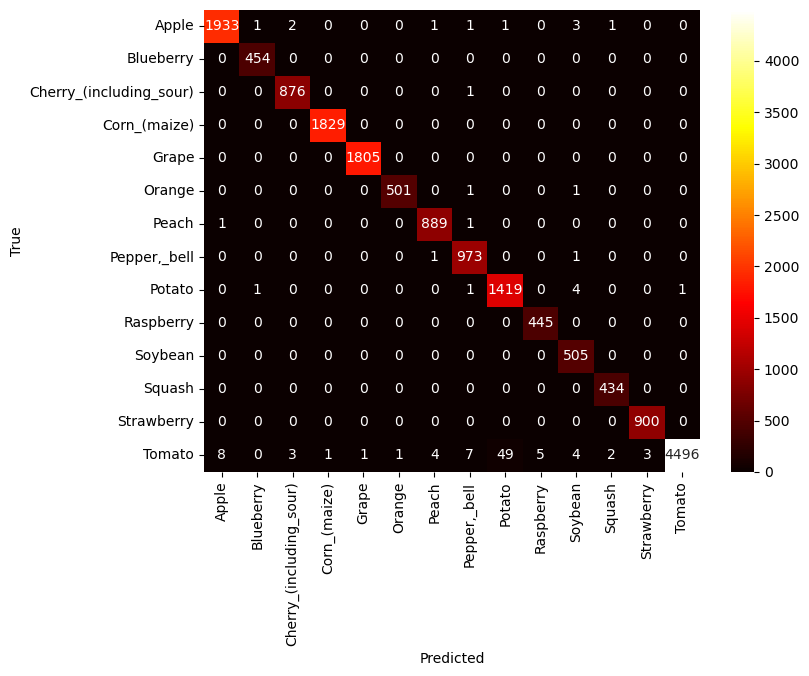

In [58]:
#Création de la matrice de confusion
eNetV2B3_plant_confusion_matrix = confusion_matrix(plant_true_classes, eNetV2B3_plant_predicted_classes) 

#Création d'une heatmap de la matrice de confusion
plt.figure(figsize=(8,6))
sns.heatmap(eNetV2B3_plant_confusion_matrix, 
            annot=True, fmt='d', 
            xticklabels=plant_class_labels, yticklabels=plant_class_labels, 
            cmap='hot')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [59]:
#Création du rapport de classification
eNetV2B3_plant_report = classification_report(plant_true_classes, eNetV2B3_plant_predicted_classes, 
                                               target_names=plant_class_labels)

print(eNetV2B3_plant_report)

                         precision    recall  f1-score   support

                  Apple       1.00      0.99      1.00      1943
              Blueberry       1.00      1.00      1.00       454
Cherry_(including_sour)       0.99      1.00      1.00       877
           Corn_(maize)       1.00      1.00      1.00      1829
                  Grape       1.00      1.00      1.00      1805
                 Orange       1.00      1.00      1.00       503
                  Peach       0.99      1.00      1.00       891
           Pepper,_bell       0.99      1.00      0.99       975
                 Potato       0.97      1.00      0.98      1426
              Raspberry       0.99      1.00      0.99       445
                Soybean       0.97      1.00      0.99       505
                 Squash       0.99      1.00      1.00       434
             Strawberry       1.00      1.00      1.00       900
                 Tomato       1.00      0.98      0.99      4584

               accuracy

#### 2. Evalutation du modèle EfficientNetV2S

In [60]:
#Obtenir les prédictions du modèle
eNetV2S_plant_predictions = eNetV2S_classifier_plant.predict(valid_set_plant)
eNetV2S_plant_predicted_classes = np.argmax(eNetV2S_plant_predictions, axis=1)

275/275 [==============================] - 115s 415ms/step


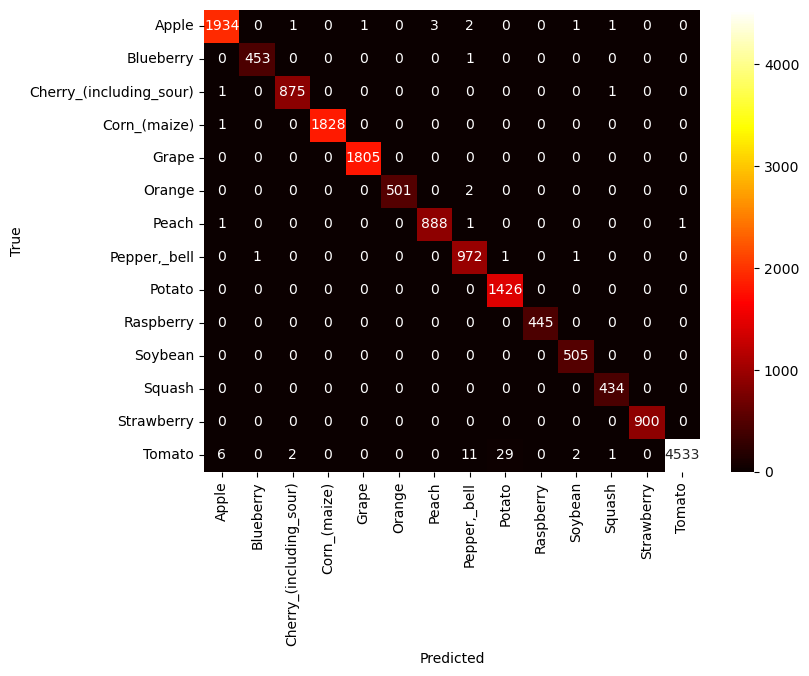

In [61]:
#Création de la matrice de confusion
eNetV2S_plant_confusion_matrix = confusion_matrix(plant_true_classes, eNetV2S_plant_predicted_classes) 

#Création d'une heatmap de la matrice de confusion
plt.figure(figsize=(8,6))
sns.heatmap(eNetV2S_plant_confusion_matrix, 
            annot=True, fmt='d', 
            xticklabels=plant_class_labels, yticklabels=plant_class_labels, 
            cmap='hot')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [62]:
#Création du rapport de classification
eNetV2S_plant_report = classification_report(plant_true_classes, eNetV2S_plant_predicted_classes, 
                                               target_names=plant_class_labels)

print(eNetV2S_plant_report)

                         precision    recall  f1-score   support

                  Apple       1.00      1.00      1.00      1943
              Blueberry       1.00      1.00      1.00       454
Cherry_(including_sour)       1.00      1.00      1.00       877
           Corn_(maize)       1.00      1.00      1.00      1829
                  Grape       1.00      1.00      1.00      1805
                 Orange       1.00      1.00      1.00       503
                  Peach       1.00      1.00      1.00       891
           Pepper,_bell       0.98      1.00      0.99       975
                 Potato       0.98      1.00      0.99      1426
              Raspberry       1.00      1.00      1.00       445
                Soybean       0.99      1.00      1.00       505
                 Squash       0.99      1.00      1.00       434
             Strawberry       1.00      1.00      1.00       900
                 Tomato       1.00      0.99      0.99      4584

               accuracy